# SMP and snow pit profile matching
An example of SMP profiles at snow pit locations are scaled to account for differences
in the target snowpack structure. Because the SMP and density cutter profiles are physically
displaced we use a brute-force approach to match them as best as possible using a 4 step
procedure

1. Make a first guess at the density from the SMP using the P15
2. Break up the SMP profile into L_RESAMPLE sized layers
3. Randomly scale each layer according to MAX_STRETCH_LAYER
4. Compare against density profile
5. Select best fit scaling where RMSE and R are optimized


In [1]:
# Community packages
import os 
import numpy as np
np.random.seed(2019) 
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import ConnectionPatch
from scipy import stats
from statsmodels.formula.api import ols
import pickle


# Local packages
import smpfunc #SMP helper functions

# Import SLF SMP Package
from snowmicropyn import Profile, proksch2015, loewe2012

# Import data
pit_summary = pd.read_csv("./data/Pit/pit_summary.csv")
pit_desnity = pd.read_csv("./data/Pit/pit_density.csv")
input_data = os.path.abspath("./data/SMP/Calibration")

# Set constants
CUTTER_SIZE = 15 # Half the height of the density cutter in mm
WINDOW_SIZE = 5 # SMP analysis window in mm
H_RESAMPLE = 1 # delta height in mm for standardized SMP profiles
L_RESAMPLE = 50 # layer unit height in mm for SMP matching
MAX_STRETCH_LAYER = 0.75 # Max layer change in % of height
MAX_STRETCH_OVERALL = 0.15 # Max profile change in % of total height
NUM_TESTS = 10000

#coeffs = pickle.load(open('./output/density_kfolds_coeffs.sav', 'rb'))

axis_value_size = 12
axis_label_size = 14

coeffs = pickle.load(open('./output/density_k19b_coeffs.pkl', 'rb'))

In [2]:
# Load the SMP calibration profiles, should be 25 for the ECCC case
def load_smp(smp_file):
    p = Profile.load(smp_file)
    p = smpfunc.preprocess(p, smoothing = 0)
    ground  = p.detect_ground()
    surface  = p.detect_surface()
    return p

file_list = []
for file in os.listdir(input_data):
    if file.endswith(".pnt"):
        file_list.append(os.path.join(input_data, file))
        
smp_data = [load_smp(file) for file in file_list]

C:\Users\kingj\Miniconda3\envs\smp-sea-ice\lib\site-packages\snowmicropyn\detection.py:24: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  i_ol = force.argmax()


In [3]:
smp = smp_data[11]
smp_file_num = int(smp.name[-4:])
pit_df  = pit_summary[pit_summary['SMPF'] == smp_file_num] # Select the matching pit
density_df = pit_desnity[pit_desnity['ID'] == pit_df['ID'].values[0]]
density_df = density_df.assign(relative_height=np.abs(((density_df['TOP']*10) - CUTTER_SIZE) - density_df['TOP'].max()*10).values)
# Make first guess at microstructure based on original profile
l2012 = loewe2012.calc(smp.samples_within_snowpack(), window=WINDOW_SIZE)
p2015 = proksch2015.calc(smp.samples_within_snowpack(), window=WINDOW_SIZE)

# Estimate offset of the snow depth and SMP profile
smp_profile_height = p2015.distance.max()
smp_height_diff = pit_df.MPD.values*1000 - smp_profile_height

# Create new SMP resampled arrays and determine the number of layers
depth_array = np.arange(0, p2015.distance.max() + smp_height_diff, H_RESAMPLE)
density_array = np.interp(depth_array,p2015.distance,p2015.P2015_density)
force_array = np.interp(depth_array,p2015.distance,l2012.force_median)
l_array = np.interp(depth_array,p2015.distance,l2012.L2012_L)

smp_df = pd.DataFrame({'distance': depth_array, 
                       'density': density_array,
                       'force_median': force_array,
                       'l': l_array})

num_sections = np.ceil(len(smp_df.index)/L_RESAMPLE).astype(int)
random_tests = [smpfunc.random_stretch(x, MAX_STRETCH_OVERALL, MAX_STRETCH_LAYER) for x in np.repeat(num_sections, NUM_TESTS)] 

scaled_profiles = [smpfunc.scale_profile(test, smp_df.distance.values, smp_df.density.values, L_RESAMPLE, H_RESAMPLE) for test in random_tests]
compare_profiles = [smpfunc.extract_samples(dist, rho, density_df.relative_height.values, CUTTER_SIZE) for dist, rho in scaled_profiles]
compare_profiles = [pd.concat([profile, density_df.reset_index()], axis=1, sort=False) for profile in compare_profiles]
retrieved_skill = [smpfunc.calc_skill(profile, CUTTER_SIZE) for profile in compare_profiles]
retrieved_skill = pd.DataFrame(retrieved_skill,columns = ['r','rmse','rmse_corr','mae'])

C:\Users\kingj\Miniconda3\envs\smp-sea-ice\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [4]:
min_scaling_idx = retrieved_skill.sort_values(['r', 'rmse_corr'], ascending=[False, True]).head(1).index.values
min_scaling_coeff = random_tests[int(min_scaling_idx)]

dist, scaled_l =  smpfunc.scale_profile(min_scaling_coeff, smp_df.distance.values, smp_df.l.values, L_RESAMPLE, H_RESAMPLE)
dist, scaled_force_median = smpfunc.scale_profile(min_scaling_coeff, smp_df.distance.values, smp_df.force_median.values, L_RESAMPLE, H_RESAMPLE)

result = compare_profiles[int(min_scaling_idx)].assign(l=smpfunc.extract_samples(dist, scaled_l, density_df.relative_height.values, CUTTER_SIZE).mean_samp,
                                          force_median=smpfunc.extract_samples(dist, scaled_force_median, density_df.relative_height.values, CUTTER_SIZE).mean_samp)

In [5]:
layer_thickness_scaled = L_RESAMPLE + (min_scaling_coeff * L_RESAMPLE)
layer_height_scalled = layer_thickness_scaled.cumsum()

layer_thickness = np.repeat(L_RESAMPLE, num_sections)
layer_height = layer_thickness.cumsum()

In [6]:
# Change in thickness
print((depth_array.max() - layer_thickness_scaled.sum())/depth_array.max())

-0.06472459515288834


In [7]:
density_k2019 = coeffs[0] + coeffs[1] * np.log(scaled_force_median) \
          + coeffs[2] * np.log(scaled_force_median) * scaled_l \
          + coeffs[3] * scaled_l

C:\Users\kingj\Miniconda3\envs\smp-sea-ice\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kingj\Miniconda3\envs\smp-sea-ice\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


#### Figure 3 with caption
![png](./output/figures/Fig03_matching_lowres.png)
#### Example of the SMP processing workflow to align first guess estimates of ρ_smp (Black lines) and snow pit measurements  (Red lines). Profiles are divided in arbitrary layers of 5 cm and randomly scaled in thickness. A best fit candidate is selected where RMSE between the snow density estimates and observations are minimized. The matching process is used to account for differences in the target snowpack between the two methods. The example shown is for Eureka site 5 on MYI.

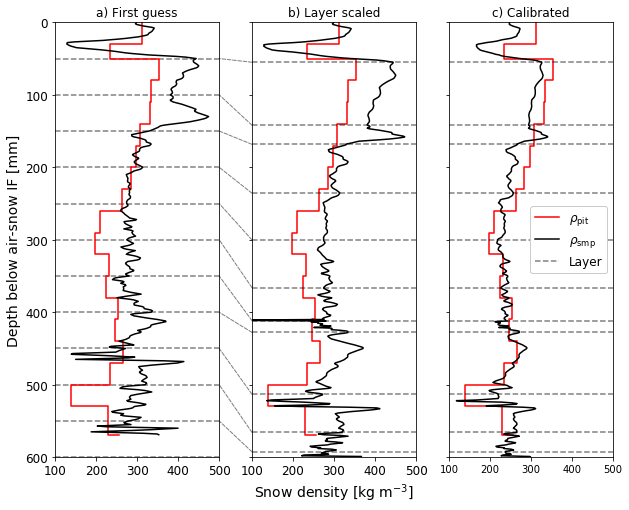

In [8]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False  # not really needed
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10,8))
ax1.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax2.tick_params(axis='both', which='major', labelsize=axis_value_size)

xmax = 500
xmin = 100

for l in layer_height:
    ax1.axhline(y=l, color = 'k', alpha = 0.5, ls = 'dashed')

ax1.step(result.RHO, result.relative_height-15, color = 'r')
ax2.step(result.RHO, result.relative_height-15, color = 'r')
ax3.step(result.RHO, result.relative_height-15, color = 'r', 
         label =  r'$\rho_{\mathrm{pit}}$')

ax1.plot(density_array, depth_array, color = 'k')

for l in layer_height_scalled:
    ax2.axhline(y=l, color = 'k', alpha = 0.5, ls = 'dashed')
    ax3.axhline(y=l, color = 'k', alpha = 0.5, ls = 'dashed')


    
ax2.plot(scaled_profiles[int(min_scaling_idx)][1],
         scaled_profiles[int(min_scaling_idx)][0], color = 'k')


for i in np.arange(0, len(layer_height)-1):
    xy = (xmin, layer_height_scalled[i])
    xy1 = (xmax,layer_height[i])
    con = ConnectionPatch(xyA=xy, xyB=xy1, coordsA="data", coordsB="data",
                       axesA=ax2, axesB=ax1, color="k", alpha = 0.5, ls = 'dashed')
    ax2.add_artist(con)
    
ax3.plot(density_k2019 ,scaled_profiles[int(min_scaling_idx)][0], 
         color = 'k', label = r'$\rho_{\mathrm{smp}}$')

ax1.set_ylim(0,600)


ax1.set_xlim(xmin,xmax)
ax2.set_xlim(xmin,xmax)
ax3.set_xlim(xmin,xmax)

ax3.axhline(y=l, color = 'k', alpha = 0.5, ls = 'dashed', label = 'Layer')


ax1.set_ylabel('Depth below air-snow IF [mm]', fontsize=axis_label_size)

ax2.set_xlabel('Snow density [kg m$\mathregular{^{-3}}$]', fontsize=axis_label_size)

ax1.set_title('a) First guess')
ax2.set_title('b) Layer scaled')
ax3.set_title('c) Calibrated')

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()

ax3.legend(fontsize=12, facecolor='white', framealpha=1)

f.savefig('./output/figures/Fig03_matching_lowres.png', format='png')

In [9]:
# Correlation after alignment
np.corrcoef(result.RHO, result.mean_samp)[1][0]

0.827473258229197

In [10]:
# RMSE after alignment
np.sqrt(np.mean(result.RHO-result.mean_samp)**2)

53.133619072746626